In [2]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
from sentence_transformers import SentenceTransformer

#  Load uploaded CSV
#  Load uploaded CSV with fallback encoding
csv_file = list(uploaded.keys())[0]
try:
    df = pd.read_csv(csv_file)
except UnicodeDecodeError:
    print("[WARNING] UTF-8 decoding failed. Retrying with ISO-8859-1...")
    df = pd.read_csv(csv_file, encoding='ISO-8859-1')  # fallback


#  Preview
print("Sample rows from the uploaded file:")
print(df.head())

#  Ensure required columns exist
if 'article_content' not in df.columns or 'labels' not in df.columns:
    raise ValueError("Your CSV must contain 'article_content' and 'labels' columns!")

#  Load BERT model for text embeddings
print("\n[INFO] Generating 512-dimensional embeddings using Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # fast, ~384 dim

#  Compute embeddings
embeddings = model.encode(df['article_content'].tolist(), show_progress_bar=True)

#  Convert to DataFrame and attach labels
emb_df = pd.DataFrame(embeddings)
emb_df['label'] = df['labels']

#  Save as new CSV
output_filename = "fake_news_embeddings.csv"
emb_df.to_csv(output_filename, index=False)

#  Offer download
print(f" File '{output_filename}' is ready for download.")
files.download(output_filename)

Saving FA-KES-Dataset.csv to FA-KES-Dataset (1).csv
[WARNING] UTF-8 decoding failed. Retrying with ISO-8859-1...
Sample rows from the uploaded file:
      unit_id                                      article_title  \
0  1914947530  Syria attack symptoms consistent with nerve ag...   
1  1914947532  Homs governor says U.S. attack caused deaths b...   
2  1914947533    Death toll from Aleppo bomb attack at least 112   
3  1914947534        Aleppo bomb blast kills six Syrian state TV   
4  1914947535  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                     article_content source       date  \
0  Wed 05 Apr 2017 Syria attack symptoms consiste...    nna   4/5/2017   
1  Fri 07 Apr 2017 at 0914 Homs governor says U.S...    nna   4/7/2017   
2  Sun 16 Apr 2017 Death toll from Aleppo bomb at...    nna  4/16/2017   
3  Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...    nna  4/19/2017   
4  Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...    nna  7/10/2016  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

 File 'fake_news_embeddings.csv' is ready for download.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1, Loss: 14.5905, Val Accuracy: 0.5528
Validation RMSE: 0.4985, R²: -0.0054
Epoch 2, Loss: 14.5288, Val Accuracy: 0.5404
Validation RMSE: 0.4987, R²: -0.0060
Epoch 3, Loss: 14.5333, Val Accuracy: 0.5031
Validation RMSE: 0.4995, R²: -0.0091
Epoch 4, Loss: 14.4853, Val Accuracy: 0.5466
Validation RMSE: 0.4988, R²: -0.0062
Epoch 5, Loss: 14.5247, Val Accuracy: 0.5280
Validation RMSE: 0.4997, R²: -0.0101
Epoch 6, Loss: 14.1146, Val Accuracy: 0.4472
Validation RMSE: 0.5111, R²: -0.0567
Epoch 7, Loss: 14.2537, Val Accuracy: 0.4969
Validation RMSE: 0.5059, R²: -0.0354
Epoch 8, Loss: 13.7328, Val Accuracy: 0.5155
Validation RMSE: 0.5134, R²: -0.0660
Epoch 9, Loss: 13.7000, Val Accuracy: 0.5342
Validation RMSE: 0.5148, R²: -0.0720
Epoch 10, Loss: 13.6610, Val Accuracy: 0.4907
Validation RMSE: 0.5251, R²: -0.1153
Epoch 11, Loss: 13.4495, Val Accuracy: 0.5031
Validation RMSE: 0.5211, R²: -0.0983
Epoch 12, Loss: 13.7957, Val Accuracy: 0.5217
Validation RMSE: 0.5180, R²: -0.0853
Epoch 13, Los

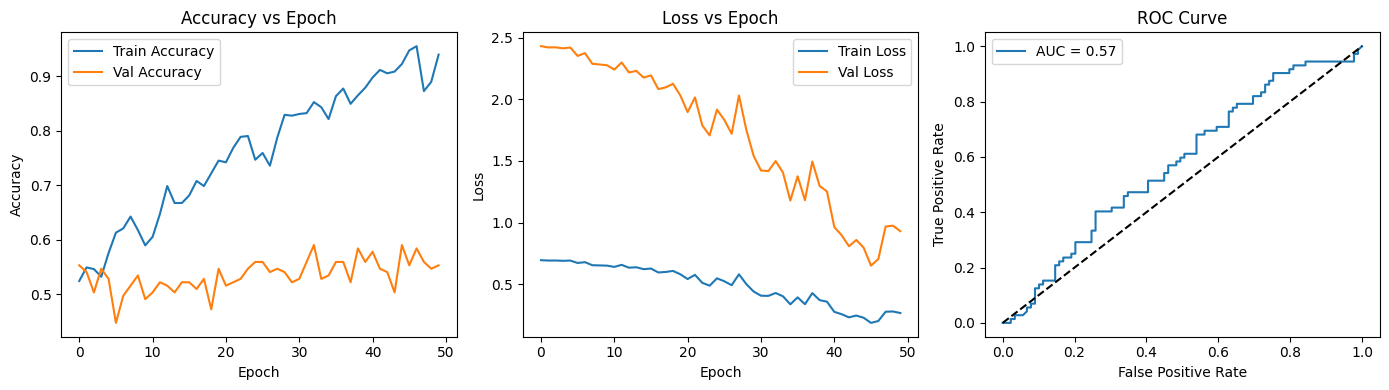

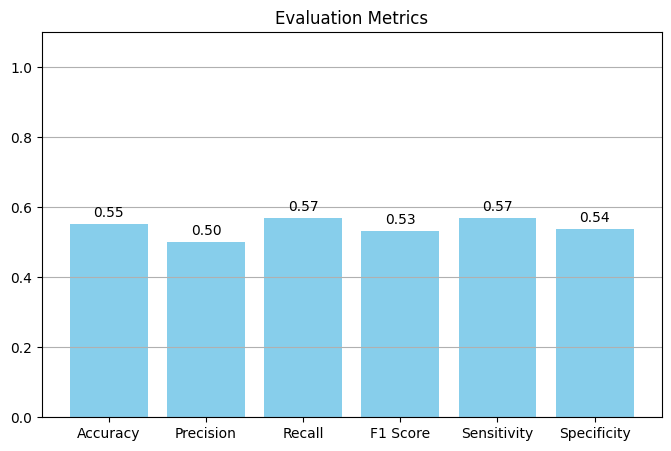

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# -------------------------------
# AWLSTM Cell
# -------------------------------
class AWLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AWLSTMCell, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.project = nn.Linear(input_size, hidden_size)

    def forward(self, x, hx=None):
        lstm_out, (hn, cn) = self.lstm(x, hx)
        x_trimmed = x[:, -lstm_out.size(1):, :]
        x_proj = self.project(x_trimmed.reshape(-1, x_trimmed.shape[2]))
        x_proj = x_proj.view(x.size(0), -1, lstm_out.size(2))
        output = self.alpha * lstm_out + (1 - self.alpha) * x_proj
        return output, (hn, cn)

# -------------------------------
# CNN + AWLSTM Model
# -------------------------------
class DeepfakeCNNRNN(nn.Module):
    def __init__(self, input_dim=384, cnn_channels=64, rnn_hidden_size=128):
        super(DeepfakeCNNRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.input_proj = nn.Linear(cnn_channels, rnn_hidden_size)
        self.rnn = AWLSTMCell(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)             # (batch, 1, 384)
        x = self.cnn(x)                # (batch, 64, 96)
        x = x.permute(0, 2, 1)         # (batch, 96, 64)
        x = self.input_proj(x)         # (batch, 96, 128)
        out, _ = self.rnn(x)           # (batch, 96, 128)
        return self.classifier(out[:, -1])  # (batch, 1)

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv("fake_news_embeddings.csv")
X = df.drop(columns=["label"]).values.astype(np.float32)
y = df["label"].values.astype(np.float32)
y = 1 - y  # optional flip

# Scale input
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Dataset and Dataloader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# -------------------------------
# Train Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeCNNRNN(input_dim=384).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Train accuracy
    model.eval()
    train_preds, train_targets = [], []
    with torch.no_grad():
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            train_preds.extend(preds.view(-1).round().cpu().numpy())
            train_targets.extend(yb.view(-1).cpu().numpy())

    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    val_probs, val_preds, val_targets = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_probs.extend(preds.view(-1).cpu().numpy())
            val_preds.extend(preds.view(-1).round().cpu().numpy())
            val_targets.extend(yb.view(-1).cpu().numpy())

    acc = accuracy_score(val_targets, val_preds)
    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(acc)
    rmse = np.sqrt(mean_squared_error(val_targets, val_probs))
    r2 = r2_score(val_targets, val_probs)

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Accuracy: {acc:.4f}")
    print(f"Validation RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -------------------------------
# Save Model
# -------------------------------
torch.save(model.state_dict(), "deepfake_cnn_awlstmm.pth")

# -------------------------------
# Evaluation Metrics + Plotting
# -------------------------------
y_true = np.array(val_targets)
y_pred = np.array(val_preds)
probs = np.array(val_probs)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = recall  # same as recall

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# -------------------------------
# Plots
# -------------------------------

# Accuracy Plot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

# ROC Curve
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation Metric Bar Plot
scores = [acc, precision, recall, f1, sensitivity, specificity]
labels = ["Accuracy", "Precision", "Recall", "F1 Score", "Sensitivity", "Specificity"]

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color='skyblue')
plt.title("Evaluation Metrics")
plt.ylim(0, 1.1)
plt.grid(axis='y')
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()
